In [1]:
import scanpy as sc
import pandas as pd
import celltypist
import json
import matplotlib.pyplot as plt
from celltypist import models

RANDOM_STATE = 42
RESULTS_FOLDER = 'results/'
DATA_PATH = 'GSE194078'
MODEL_PATH = 'results/Immune_All_High_GSE239626_model.pkl'

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Import New Dataset

In [2]:
adata = sc.read(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 110565 × 36601
    obs: 'batch'
    var: 'gene_ids', 'feature_types'

In [13]:
adata.var_names_make_unique()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [14]:
adata.X

<110565x36601 sparse matrix of type '<class 'numpy.float32'>'
	with 221207022 stored elements in Compressed Sparse Row format>

### Predictions

In [5]:
predictions = celltypist.annotate(
    adata,
    model=MODEL_PATH,
    majority_voting=True,
    mode='best match'
    )

🔬 Input data has 110565 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
c:\Users\giuli\anaconda3\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


In [6]:
predictions

CellTypist prediction result for 110565 query cells
    predicted_labels: data frame with 3 columns ('predicted_labels', 'over_clustering', 'majority_voting')
    decision_matrix: data frame with 110565 query cells and 32 cell types
    probability_matrix: data frame with 110565 query cells and 32 cell types
    adata: AnnData object referred

In [7]:
predictions.predicted_labels.to_csv(RESULTS_FOLDER+'celltypist_transfer_labels_GSE194078.csv')

### Results

In [8]:
predictions.predicted_labels.head()

,predicted_labels,over_clustering,majority_voting
AAACCCACAAGACCGA-1_PBMC,Monocytes,706,Monocytes
AAACCCACACGGCACT-1_PBMC,T cells,763,T cells
AAACCCATCAGAATAG-1_PBMC,T cells,829,T cells
AAACGAAAGGTAAAGG-1_PBMC,T cells,332,T cells
AAACGAACACAGCCAC-1_PBMC,T cells,113,T cells


In [9]:
len(predictions.predicted_labels['predicted_labels'].unique())

23

In [18]:
adata.obs.index.value_counts()

CTTCAATGTTTGGGAG-11_PBMC    2
GTTGTAGAGCGTTGTT-11_PBMC    2
GGTTCTCCATTGCTGA-11_PBMC    2
GTCAGCGGTCCTTGTC-11_PBMC    2
GAAACCTGTATGGAAT-11_PBMC    2
                           ..
GGGCCATTCAAGTCTG-6_PBMC     1
GGGCCATGTGGTCCCA-6_PBMC     1
GGGCCATGTGAATATG-6_PBMC     1
GGGCCATGTCTGTCAA-6_PBMC     1
TTTGTTGTCTCCTGTG-11_CSF     1
Name: count, Length: 110559, dtype: int64

In [10]:
adata.obs['predicted_labels'] = predictions.predicted_labels['predicted_labels']

ValueError: cannot reindex on an axis with duplicate labels

KeyError: 'Could not find key predicted_labels in .var_names or .obs.columns.'

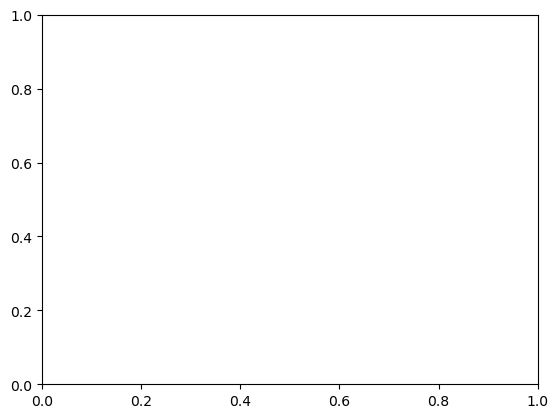

In [ ]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=['predicted_labels'], color_map='tab20')

In [ ]:
adata.obs['predicted_labels'].value_counts()

In [ ]:
labels = adata.obs['predicted_labels'].value_counts()[adata.obs['predicted_labels'].value_counts() > 1].index
labels

In [ ]:
adata = adata[adata.obs['predicted_labels'].isin(labels)]
sc.tl.rank_genes_groups(adata, groupby='predicted_labels', method='t-test')
gene_groups = adata.uns['rank_genes_groups']

In [ ]:
plt.figure(figsize=(10, 5))
ax = plt.gca()
adata.obs['predicted_labels'].value_counts().plot(kind='bar', ax=ax)
total= len(adata.obs['predicted_labels'])
for p in ax.patches:
    percentage = '{:.4f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height() + 10
    plt.annotate(percentage, (x, y), rotation=90)
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Predicted labels counts')
plt.xlabel('Annotation')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
markers = {}
for label in predictions.predicted_labels['predicted_labels'].unique():
    if label in labels:
        markers[label] = gene_groups['names'][label].tolist()[:10] # top 10 markers, for each cell type

with open(RESULTS_FOLDER+'celltypist_markers_from_transfer_labels_GSE194078.json', 'w') as f:
    json.dump(markers, f)
    
print(markers)

In [ ]:
sc.pl.dotplot(
    adata,
    markers,
    groupby="predicted_labels",
    figsize=(18, 4),
)